In [270]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-dp'
sys.path.append(EXPERIMENT_DIR)

from data import get_DLNN_dataset, get_lagrangian_trajectory, lagrangian_dynamics_fn, lagrangian_fn ,reighley_dissipation_fn
from nn_models import MLP
from dlnn import DLNN

In [271]:
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'Arial'

In [272]:
args = {"input_dim":4,"hidden_dim":512,"output_dim":4,"nonlinearity":"swish"}

In [273]:
def get_model(label):
    if label =='dlnn' :
        nn_model = MLP(args["input_dim"], args["hidden_dim"], 2, args["nonlinearity"])
        model = DLNN(model=nn_model)
        model_name = 'dlnn'
        path = '{}/dp-{}.pt'.format(EXPERIMENT_DIR,model_name)
    else :
        model = MLP(args["input_dim"], args["hidden_dim"], args["output_dim"], args["nonlinearity"])
        model_name = 'baseline'
        path = '{}/dp-{}.pt'.format(EXPERIMENT_DIR,model_name)
    model.load_state_dict(torch.load(path))
    return model

In [274]:
def integrate_model(model, t_span, y0,**kwargs):
    def fun(t, np_x):
        np_x[0] = np.mod(np_x[0],2*np.pi)
        np_x[1] = np.mod(np_x[1],2*np.pi)
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,4)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0 ,**kwargs)

In [275]:
def bc_integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        np_x[0] = np.mod(np_x[0],2*np.pi)
        np_x[1] = np.mod(np_x[1],2*np.pi)
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,4)
        dx = model(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [276]:
dlnn_model = get_model("dlnn")

In [277]:
bc_model = get_model("baseline")

In [278]:
t_span = [0,8]
y0 = np.asarray([np.pi,np.pi-1,-2,3])
t_eval = np.linspace(t_span[0], t_span[1], 8*30)
dkwargs = {'t_eval': t_eval, 'rtol': 1e-4}
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}


In [279]:
%time dlnn_ivp = integrate_model(dlnn_model, t_span, y0, **dkwargs)

CPU times: user 18 s, sys: 236 ms, total: 18.3 s
Wall time: 3.56 s


In [280]:
%time true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)

CPU times: user 6.15 s, sys: 4.39 s, total: 10.5 s
Wall time: 5.36 s


In [281]:
%time bc_ivp = bc_integrate_model(bc_model, t_span, y0, **kwargs)

CPU times: user 726 ms, sys: 46.5 ms, total: 772 ms
Wall time: 125 ms


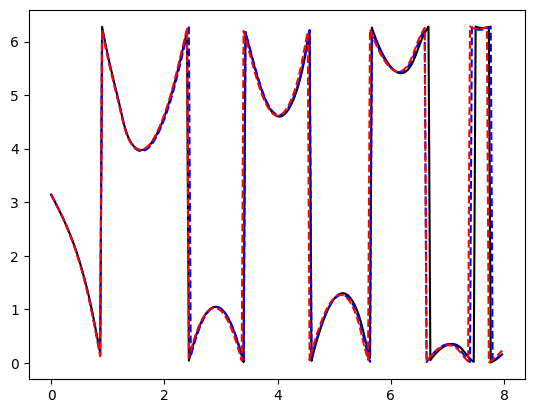

In [282]:
plt.xticks(np.arange(0,8*30+1,8*30/4),np.arange(0,8+1,2))
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k')
plt.plot(np.mod(dlnn_ivp['y'][0],2*np.pi),'b--')
plt.plot(np.mod(bc_ivp['y'][0],2*np.pi),'r--')
plt.show()

In [283]:
t_span = [0,5]
y0 = np.asarray([np.pi,np.pi*0.25,-3,3])
t_eval = np.linspace(t_span[0], t_span[1], 150)
dkwargs = {'t_eval': t_eval, 'rtol': 1e-4}
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}

In [284]:
true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)
dlnn_ivp = integrate_model(dlnn_model,t_span, y0,**kwargs)
bc_ivp = bc_integrate_model(bc_model, t_span, y0,**kwargs)

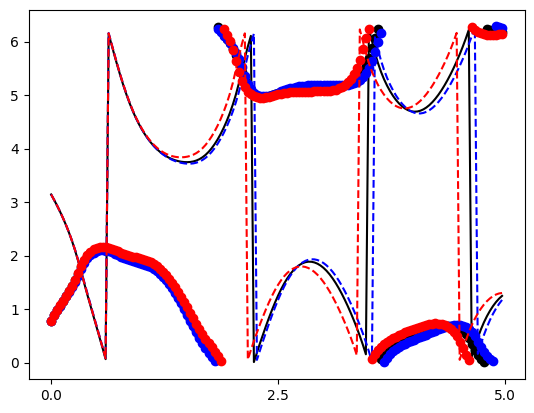

In [285]:
plt.xticks(np.arange(0,5*30+1,5*30/2),np.arange(0,5+1,2.5))
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k')
plt.plot(np.mod(true_ivp['y'][1],2*np.pi),'ko')

plt.plot(np.mod(dlnn_ivp['y'][0],2*np.pi),'b--')
plt.plot(np.mod(dlnn_ivp['y'][1],2*np.pi),'bo')

plt.plot(np.mod(bc_ivp['y'][0],2*np.pi),'r--')
plt.plot(np.mod(bc_ivp['y'][1],2*np.pi),'ro')

plt.show()

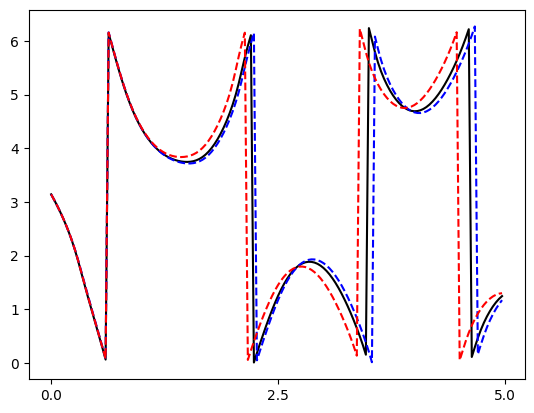

In [286]:
plt.xticks(np.arange(0,5*30+1,5*30/2),np.arange(0,5+1,2.5))
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k')
# plt.plot(np.mod(true_ivp['y'][1],2*np.pi),'ko')

plt.plot(np.mod(dlnn_ivp['y'][0],2*np.pi),'b--')
# plt.plot(np.mod(dlnn_ivp['y'][1],2*np.pi),'bo-')

plt.plot(np.mod(bc_ivp['y'][0],2*np.pi),'r--')
# plt.plot(np.mod(bc_ivp['y'][1],2*np.pi),'ro-')

plt.show()

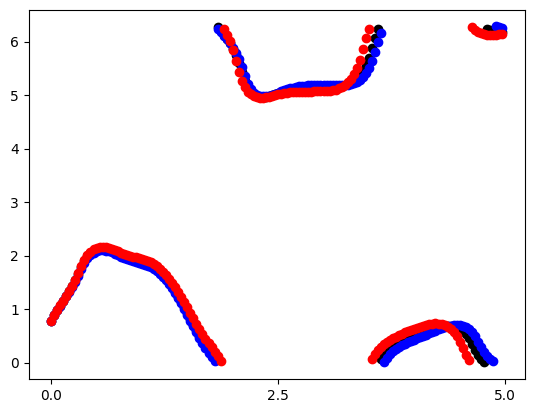

In [287]:
plt.xticks(np.arange(0,5*30+1,5*30/2),np.arange(0,5+1,2.5))
# plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k')
plt.plot(np.mod(true_ivp['y'][1],2*np.pi),'ko')

# plt.plot(np.mod(dlnn_ivp['y'][0],2*np.pi),'b--')
plt.plot(np.mod(dlnn_ivp['y'][1],2*np.pi),'bo')

# plt.plot(np.mod(bc_ivp['y'][0],2*np.pi),'r--')
plt.plot(np.mod(bc_ivp['y'][1],2*np.pi),'ro')

plt.show()

In [288]:
RHO = 2.0
GRIDSIZE = 25

In [289]:
LINE_SEGMENTS = 10
LINE_WIDTH = 40
ARROW_SCALE = 100
ARROW_WIDTH = 8e-3
qkwargs = {'width': ARROW_WIDTH, 'scale': ARROW_SCALE} # quiver kwargs

In [290]:
qs = np.arange(-np.pi ,np.pi+0.001,2*np.pi/10)
qdots = np.arange(-5,6,10/10)

input_dict = {}
for q1 in qs :
    for q2 in qs :
        for q1dot in qdots :
            for q2dot in qdots :
                input_list = [q1,q2,q1dot,q2dot]
                dict_name = ', '.join(map(str, input_list))

                y0 = np.hstack([np.mod(q1,2*np.pi),np.mod(q2,2*np.pi),q1dot,q2dot])
                Adx = lagrangian_dynamics_fn(None,y0)
                tx = torch.tensor(y0, requires_grad=True, dtype=torch.float32).view(1,4)
                DPdx = dlnn_model.time_derivative(tx).detach().numpy().reshape(4)
                BPdx = bc_model(tx).detach().numpy().reshape(4)

                output_list = [Adx,DPdx,BPdx]
                input_dict[dict_name] = output_list


In [291]:
DPpointsDiff1 = np.empty([1,3])
BPpointsDiff1 = np.empty([1,3])

DPpointDiff1 = np.empty([1,4])
BPpointDiff1 = np.empty([1,4])


for q1 in qs :
    for q1dot in qdots :
        for q2 in qs :
            for q2dot in qdots :
                input_list = [q1,q2,q1dot,q2dot]
                dict_name = ', '.join(map(str, input_list))

                Adx,DPdx,BPdx = input_dict[dict_name]

                DPpointDiff1 = np.vstack([DPpointDiff1 ,abs(Adx-DPdx)])
                BPpointDiff1 = np.vstack([BPpointDiff1 ,abs(Adx-BPdx)])

        
        DPpointsDiff1 = np.vstack([DPpointsDiff1 ,np.hstack([q1,q1dot,(DPpointDiff1[1:]**2).mean()])])
        BPpointsDiff1 = np.vstack([BPpointsDiff1 ,np.hstack([q1,q1dot,(BPpointDiff1[1:]**2).mean()])])
DPpointsDiff1 = DPpointsDiff1[1:]
BPpointsDiff1 = BPpointsDiff1[1:]

In [292]:
DPpointsDiff2 = np.empty([1,3])
BPpointsDiff2 = np.empty([1,3])

DPpointDiff2 = np.empty([1,4])
BPpointDiff2 = np.empty([1,4])


for q2 in qs :
    for q2dot in qdots :
        for q1 in qs :
            for q1dot in qdots :
                input_list = [q1,q2,q1dot,q2dot]
                dict_name = ', '.join(map(str, input_list))

                Adx,DPdx,BPdx = input_dict[dict_name]

                DPpointDiff2 = np.vstack([DPpointDiff2 ,abs(Adx-DPdx)])
                BPpointDiff2 = np.vstack([BPpointDiff2 ,abs(Adx-BPdx)])

        
        DPpointsDiff2 = np.vstack([DPpointsDiff2 ,np.hstack([q2,q2dot,(DPpointDiff2[1:]**2).mean()])])
        BPpointsDiff2 = np.vstack([BPpointsDiff2 ,np.hstack([q2,q2dot,(BPpointDiff2[1:]**2).mean()])])
DPpointsDiff2 = DPpointsDiff2[1:]
BPpointsDiff2 = BPpointsDiff2[1:]

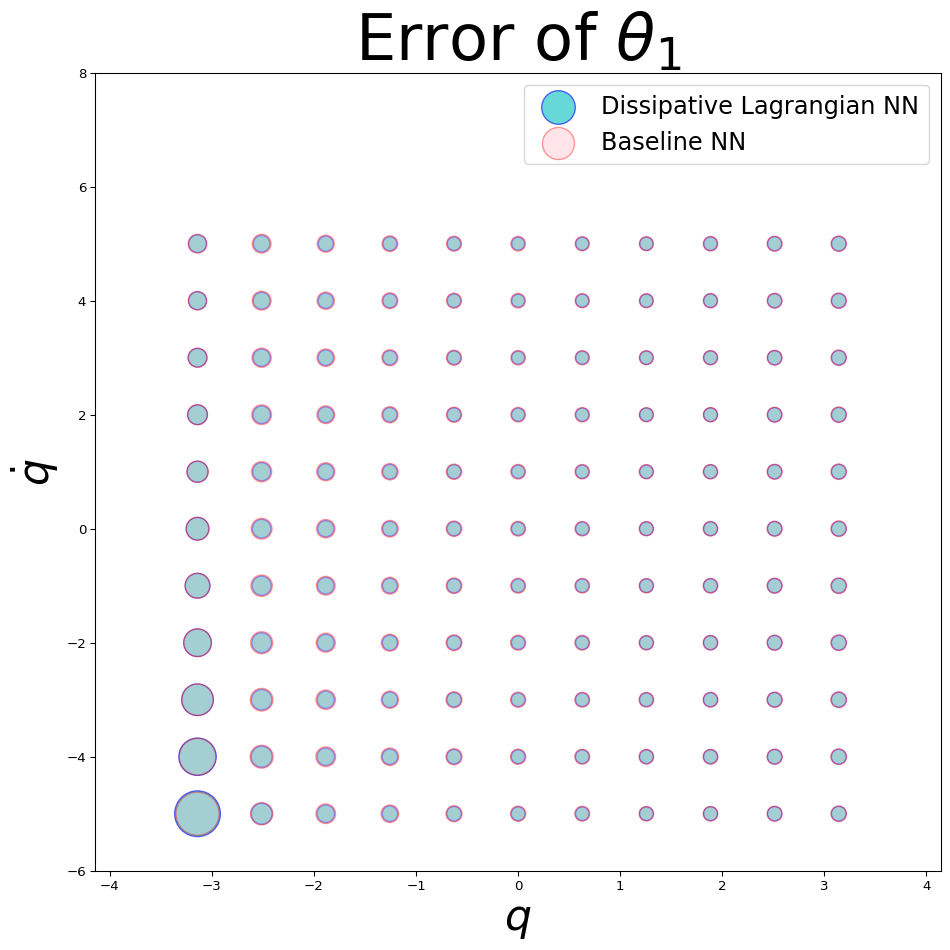

In [293]:
# fig = plt.figure(figsize=[9,6], dpi=500)
# fig = plt.figure(figsize=[6,6], dpi=500)
fig = plt.figure(figsize=[10,10], dpi=96)

plt.title(r'Error of $\theta_1$', fontsize=48)
plt.xlabel(r'$q$', fontsize=32)
plt.ylabel(r'$\dot{q}$', fontsize=32)
plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-6,8)
plt.scatter(DPpointsDiff1[:,0],DPpointsDiff1[:,1], s=DPpointsDiff1[:,2]*200,marker="o" ,alpha=0.6,c="c",linewidths=1,edgecolors="b",label="Dissipative Lagrangian NN")
plt.scatter(BPpointsDiff1[:,0],BPpointsDiff1[:,1], s=BPpointsDiff1[:,2]*200,marker="o",alpha=0.4,c="pink",linewidths=1,edgecolors="r",label="Baseline NN")

plt.legend(loc='upper right', fontsize=18)
plt.tight_layout()
plt.savefig('{}/dp_error01.png'.format(EXPERIMENT_DIR))

plt.show()



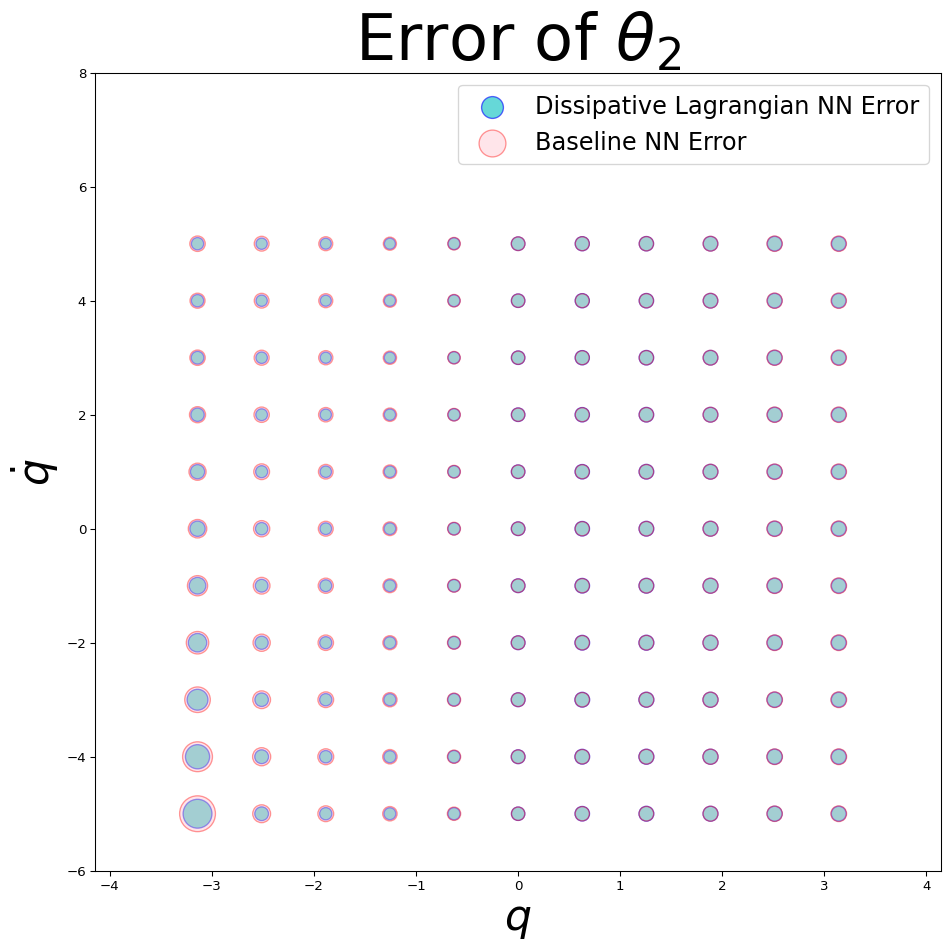

In [294]:
# fig = plt.figure(figsize=[9,6], dpi=500)
# fig = plt.figure(figsize=[6,6], dpi=500)
fig = plt.figure(figsize=[10,10], dpi=96)

plt.title(r'Error of $\theta_2$', fontsize=48)
plt.xlabel(r'$q$', fontsize=32)
plt.ylabel(r'$\dot{q}$', fontsize=32)
plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-6,8)
plt.scatter(DPpointsDiff2[:,0],DPpointsDiff2[:,1], s=DPpointsDiff2[:,2]*200,marker="o",alpha=0.6,c="c",linewidths=1,edgecolors="b",label="Dissipative Lagrangian NN Error")
plt.scatter(BPpointsDiff2[:,0],BPpointsDiff2[:,1], s=BPpointsDiff2[:,2]*200,marker="o",alpha=0.4,c="pink",linewidths=1,edgecolors="r",label="Baseline NN Error")

plt.legend(loc='upper right', fontsize=18)
plt.tight_layout()
plt.savefig('{}/dp_error02.png'.format(EXPERIMENT_DIR))

plt.show()


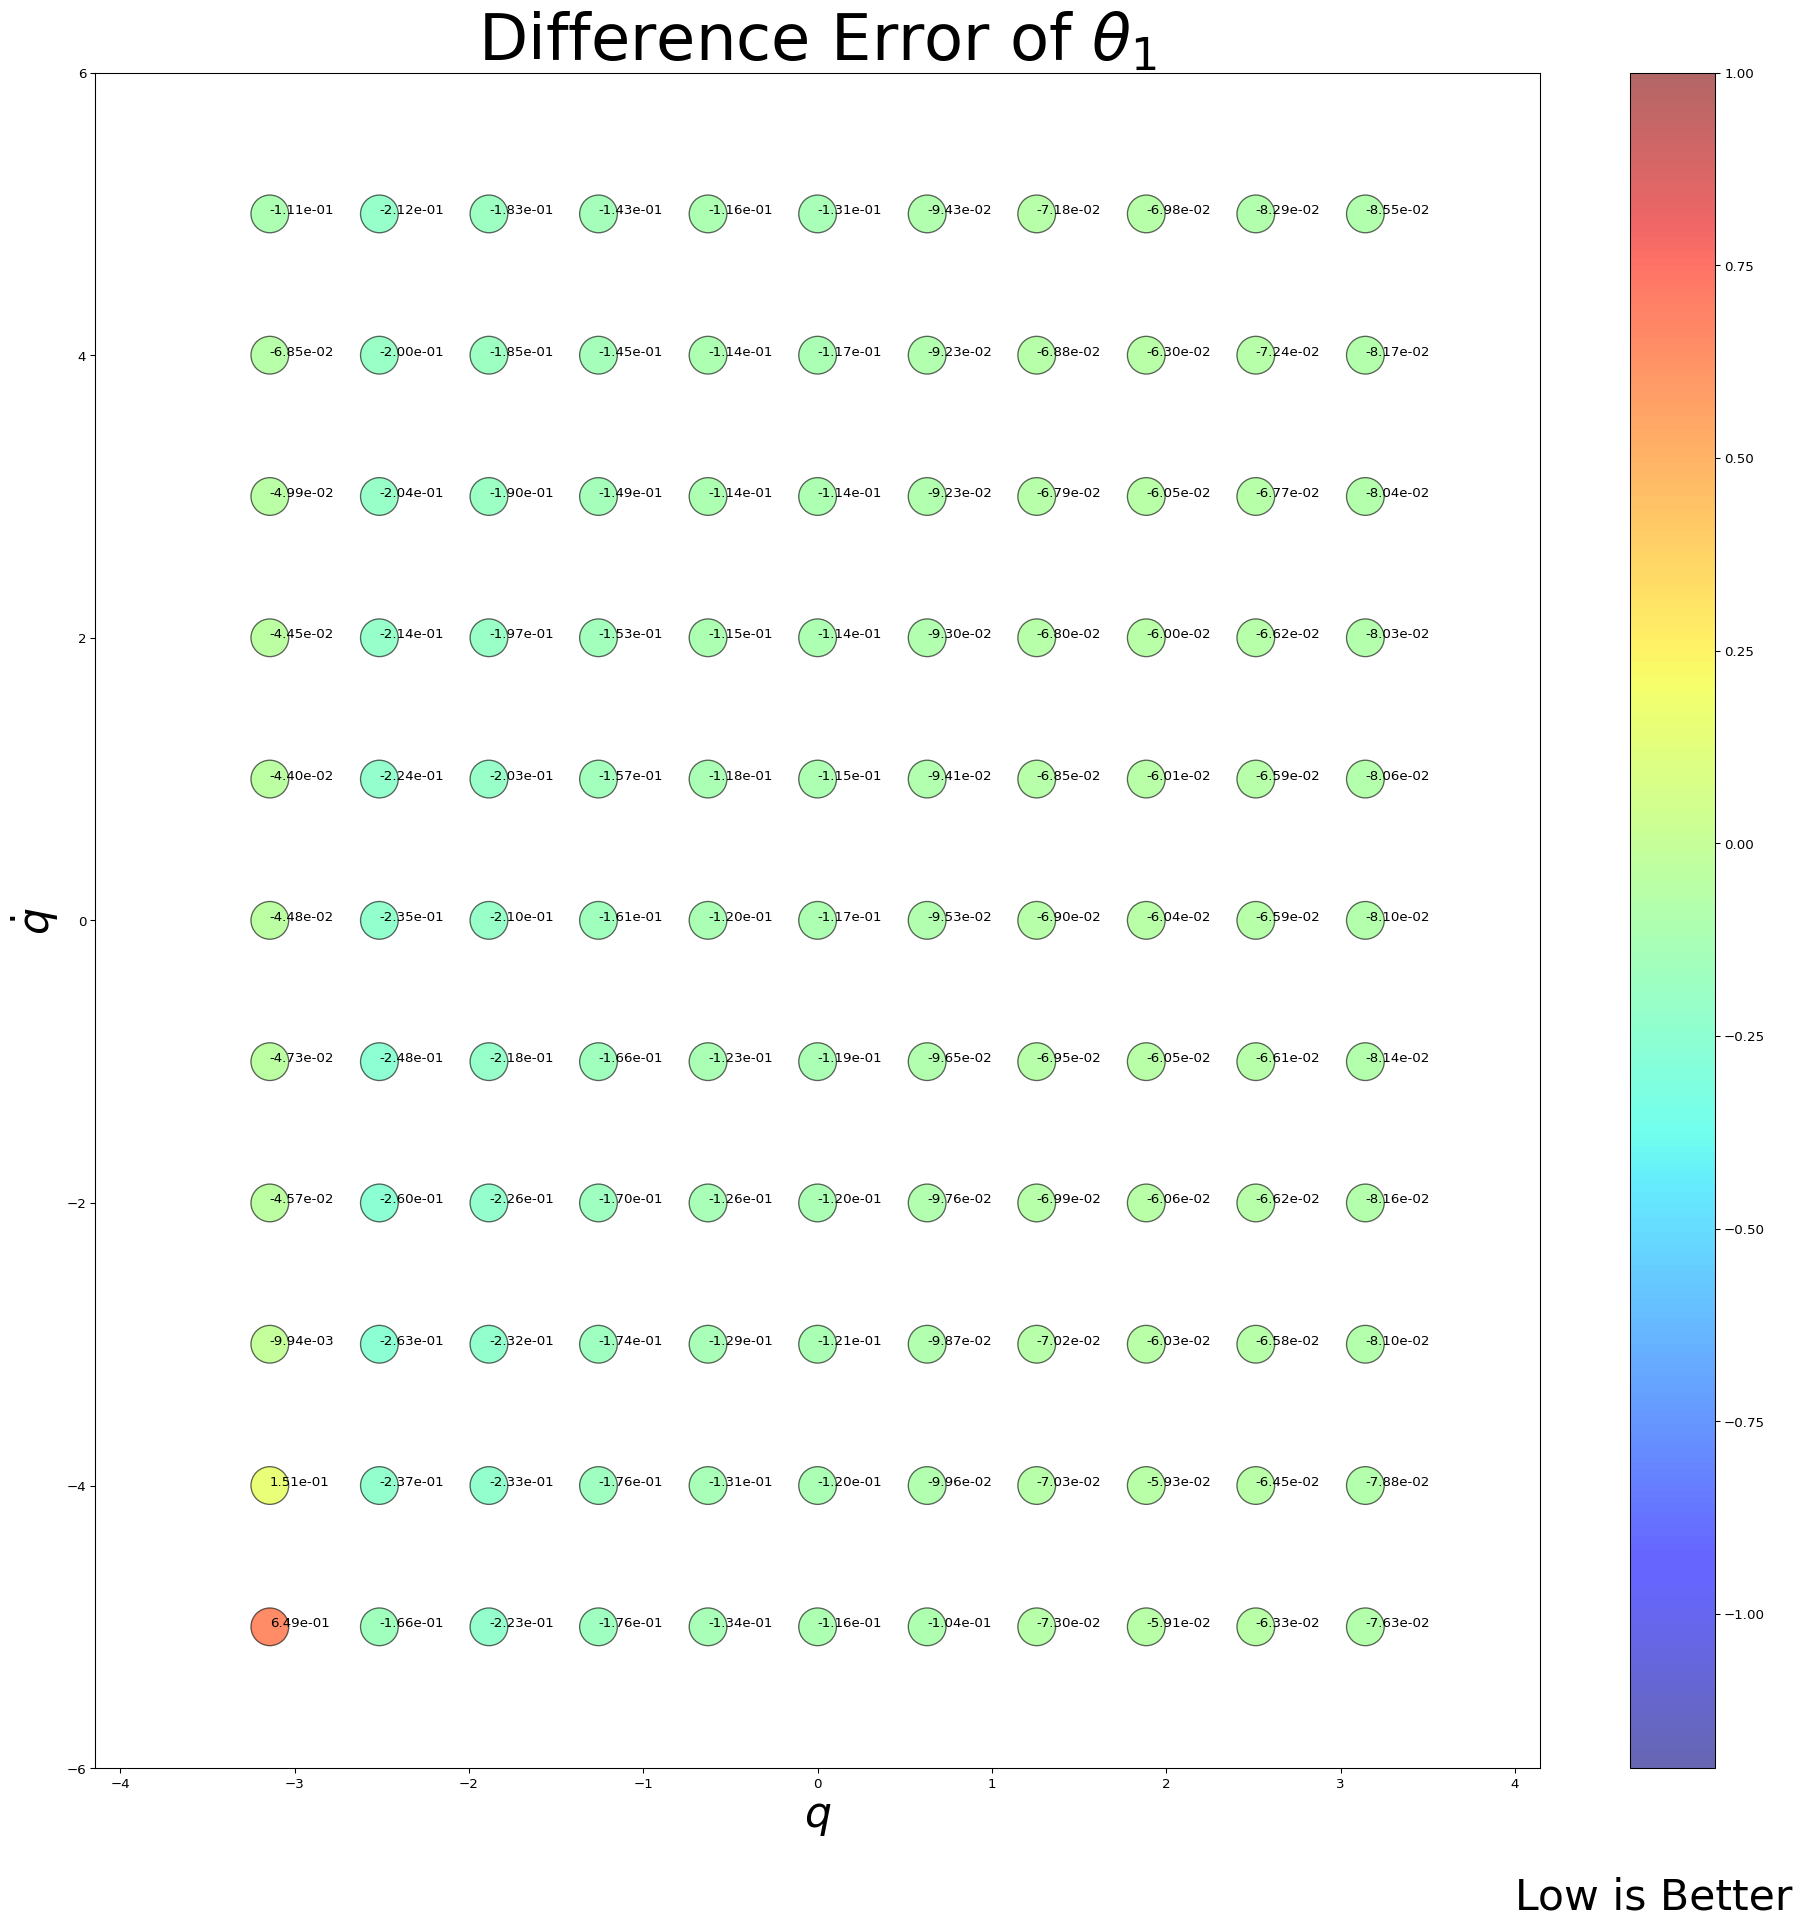

In [295]:
# fig = plt.figure(figsize=[9,6], dpi=500)
# fig = plt.figure(figsize=[6,6], dpi=500)
fig = plt.figure(figsize=[20,20], dpi=96)

plt.title(r'Difference Error of $\theta_1$', fontsize=48)
plt.xlabel(r'$q$', fontsize=32)
plt.ylabel(r'$\dot{q}$', fontsize=32)
plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-6,6)
vals = ["{:-.2e}".format(val) for val in (DPpointsDiff1[:,2]-BPpointsDiff1[:,2])]

plt.scatter(DPpointsDiff1[:,0],DPpointsDiff1[:,1], s=800,alpha=0.6,c=(DPpointsDiff1[:,2]-BPpointsDiff1[:,2]),cmap=plt.cm.jet ,linewidths=1,edgecolors="k")
for i, val in enumerate(vals):
    plt.text(DPpointsDiff1[:,0][i],DPpointsDiff1[:,1][i],val)
plt.clim(-1.2, 1)
plt.colorbar()
plt.text(4,-7, 'Low is Better', fontsize=32)
plt.tight_layout()
plt.show()


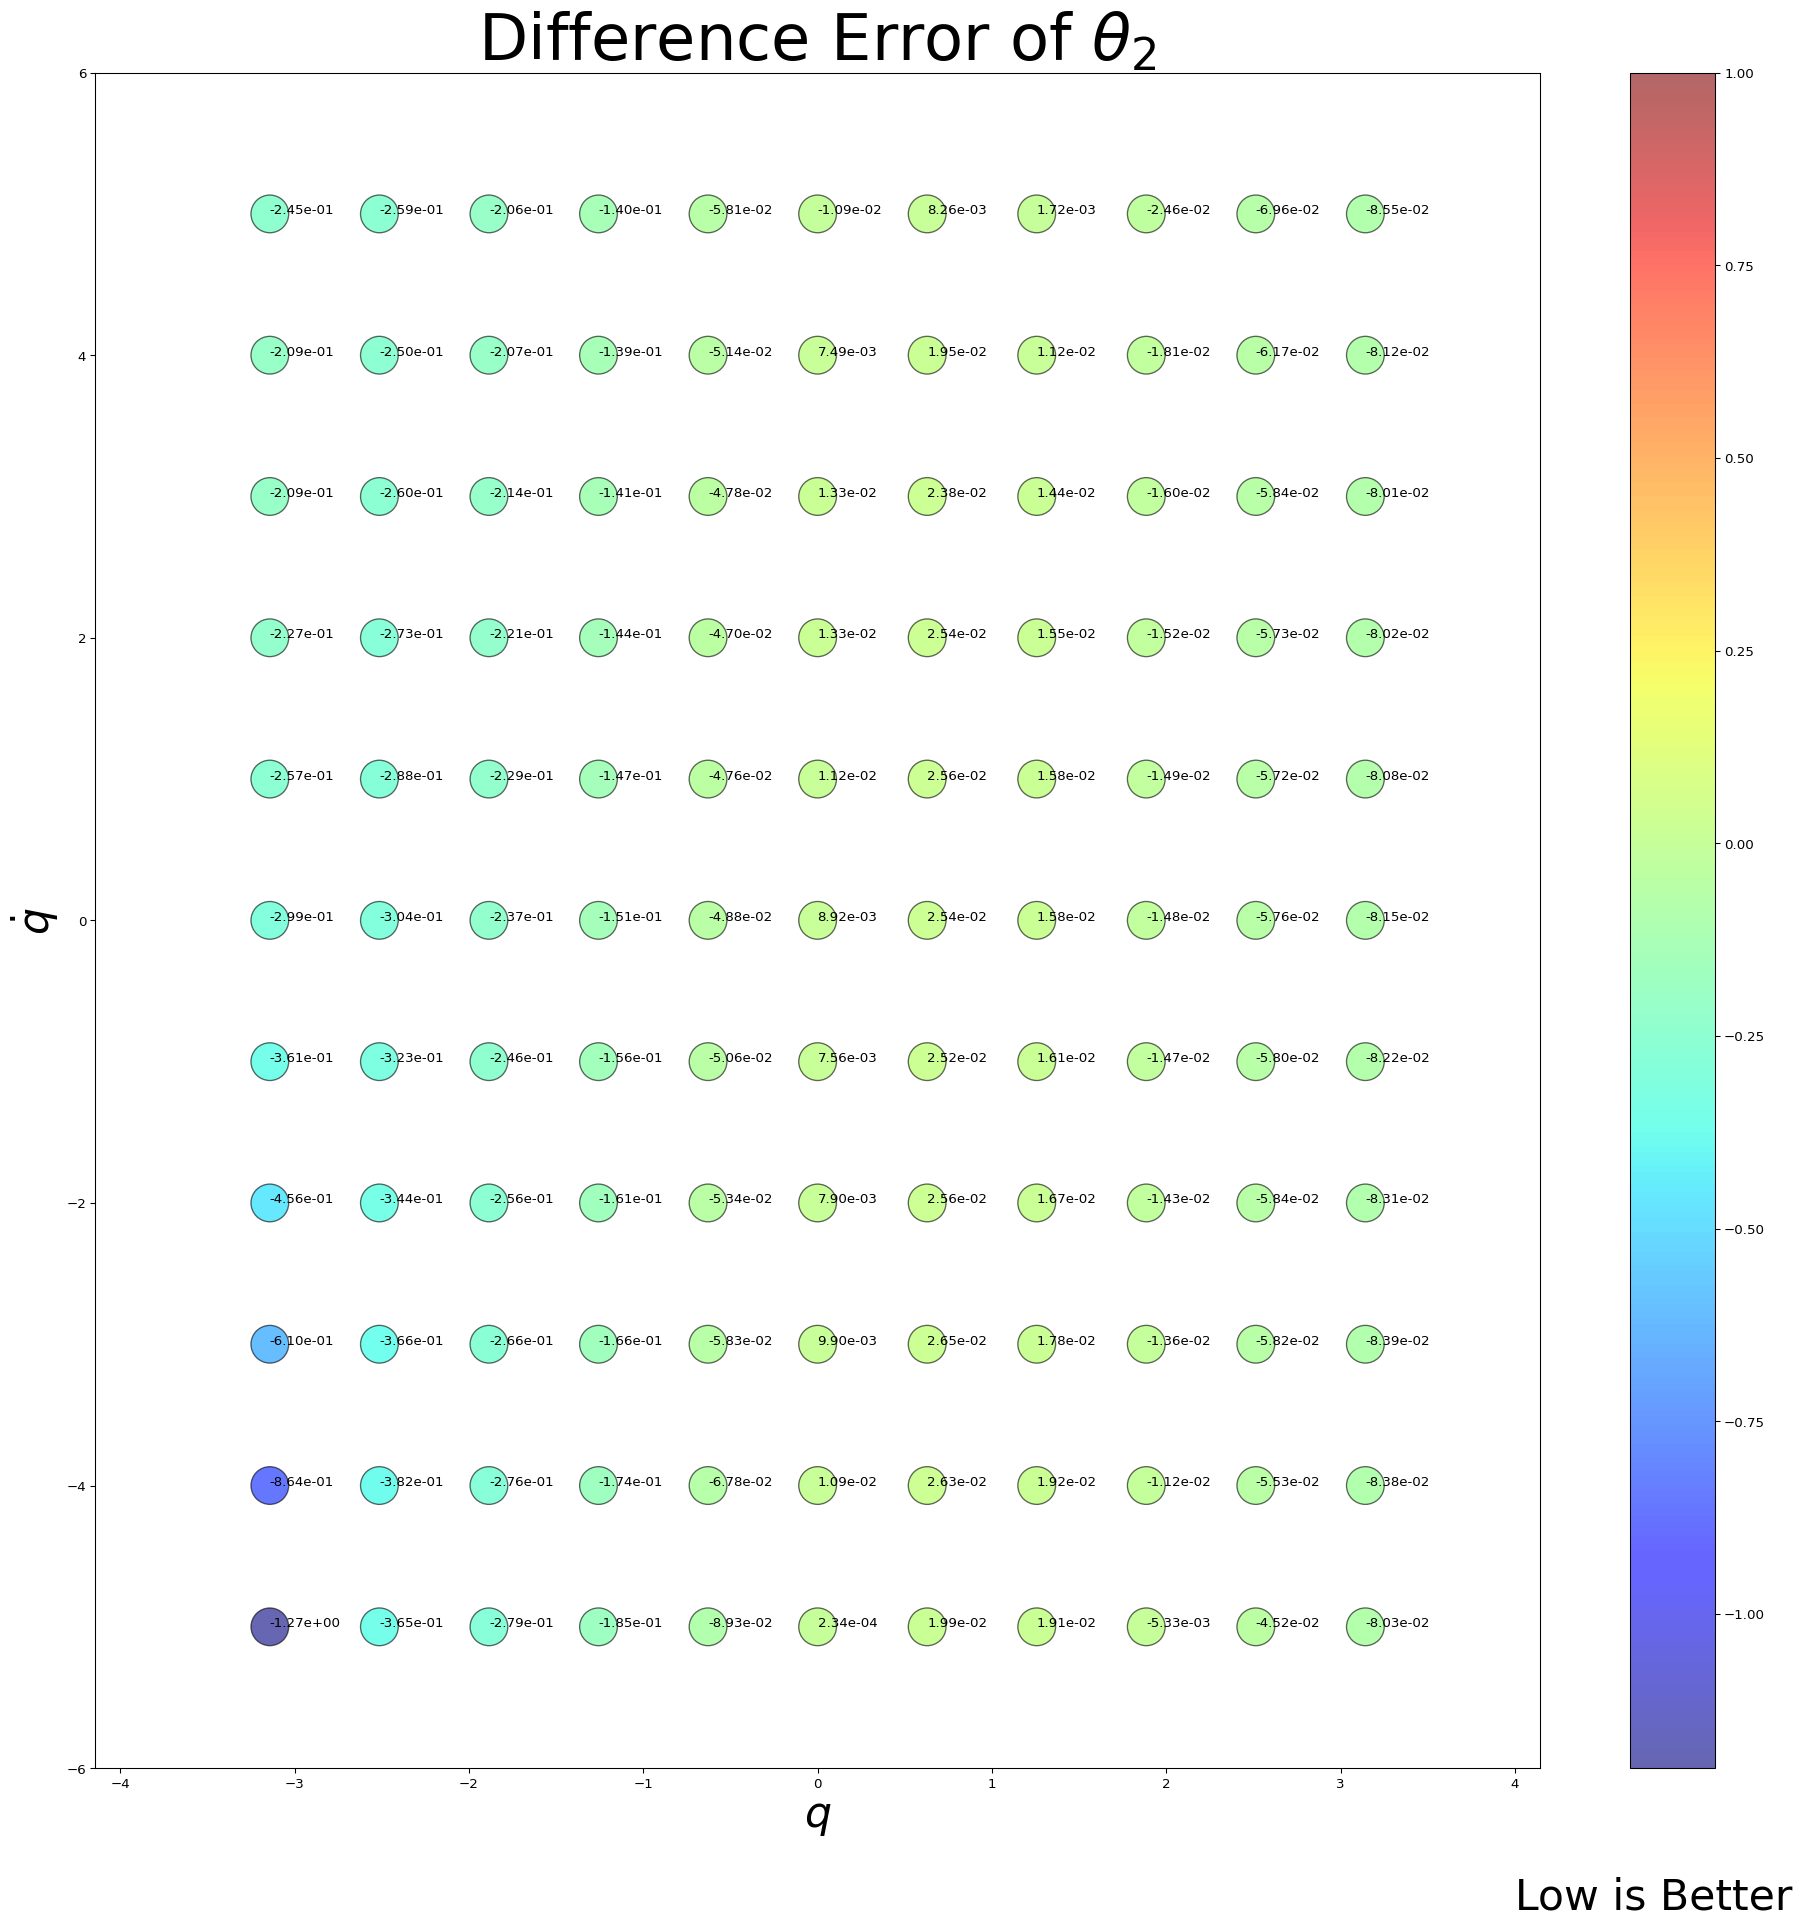

In [296]:
# fig = plt.figure(figsize=[9,6], dpi=500)
# fig = plt.figure(figsize=[6,6], dpi=500)
fig = plt.figure(figsize=[20,20], dpi=96)

plt.title(r'Difference Error of $\theta_2$', fontsize=48)
plt.xlabel(r'$q$', fontsize=32)
plt.ylabel(r'$\dot{q}$', fontsize=32)
plt.xlim(-np.pi-1,np.pi+1)
plt.ylim(-6,6)
vals = ["{:-.2e}".format(val) for val in (DPpointsDiff2[:,2]-BPpointsDiff2[:,2])]
plt.scatter(DPpointsDiff2[:,0],DPpointsDiff2[:,1], s=800,alpha=0.6,c=(DPpointsDiff2[:,2]-BPpointsDiff2[:,2]),cmap=plt.cm.jet ,linewidths=1,edgecolors="k")
for i, val in enumerate(vals):
    plt.text(DPpointsDiff2[:,0][i],DPpointsDiff2[:,1][i],val)
plt.clim(-1.2, 1)
plt.colorbar()
plt.text(4,-7, 'Low is Better', fontsize=32)
plt.tight_layout()
plt.show()

In [297]:
DMSE=(DPpointsDiff1[:,2]+DPpointsDiff2[:,2]).mean()
BMSE=(BPpointsDiff1[:,2]+BPpointsDiff2[:,2]).mean()


In [298]:
print(BMSE)
print(DMSE)

1.5244956197298558
1.2967020987561997


In [299]:
t_span = [0,15]
y0 = np.asarray([np.pi-1,np.pi-1,1,1])
t_eval = np.linspace(t_span[0], t_span[1], 15*30)
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}

In [300]:
true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)
dlnn_ivp = integrate_model(dlnn_model,t_span, y0,**kwargs)
bc_ivp = bc_integrate_model(bc_model, t_span, y0,**kwargs)

In [301]:
b1plot = np.empty(1)
for i in bc_ivp['y'][0] :
    if i >= np.pi :
        i -= 2*np.pi
    b1plot = np.hstack([b1plot,i])

b1plot = b1plot[1:]

In [302]:
b2plot = np.empty(1)
for i in bc_ivp['y'][1] :
    if i >= np.pi :
        i -= 2*np.pi
    b2plot = np.hstack([b2plot,i])

b2plot = b2plot[1:]

In [303]:
dl1plot = np.empty(1)
for i in dlnn_ivp['y'][0] :
    if i >= np.pi :
        i -= 2*np.pi
    dl1plot = np.hstack([dl1plot,i])

dl1plot = dl1plot[1:]

In [304]:
dl2plot = np.empty(1)
for i in dlnn_ivp['y'][1] :
    if i >= np.pi :
        i -= 2*np.pi
    dl2plot = np.hstack([dl2plot,i])

dl2plot = dl2plot[1:]

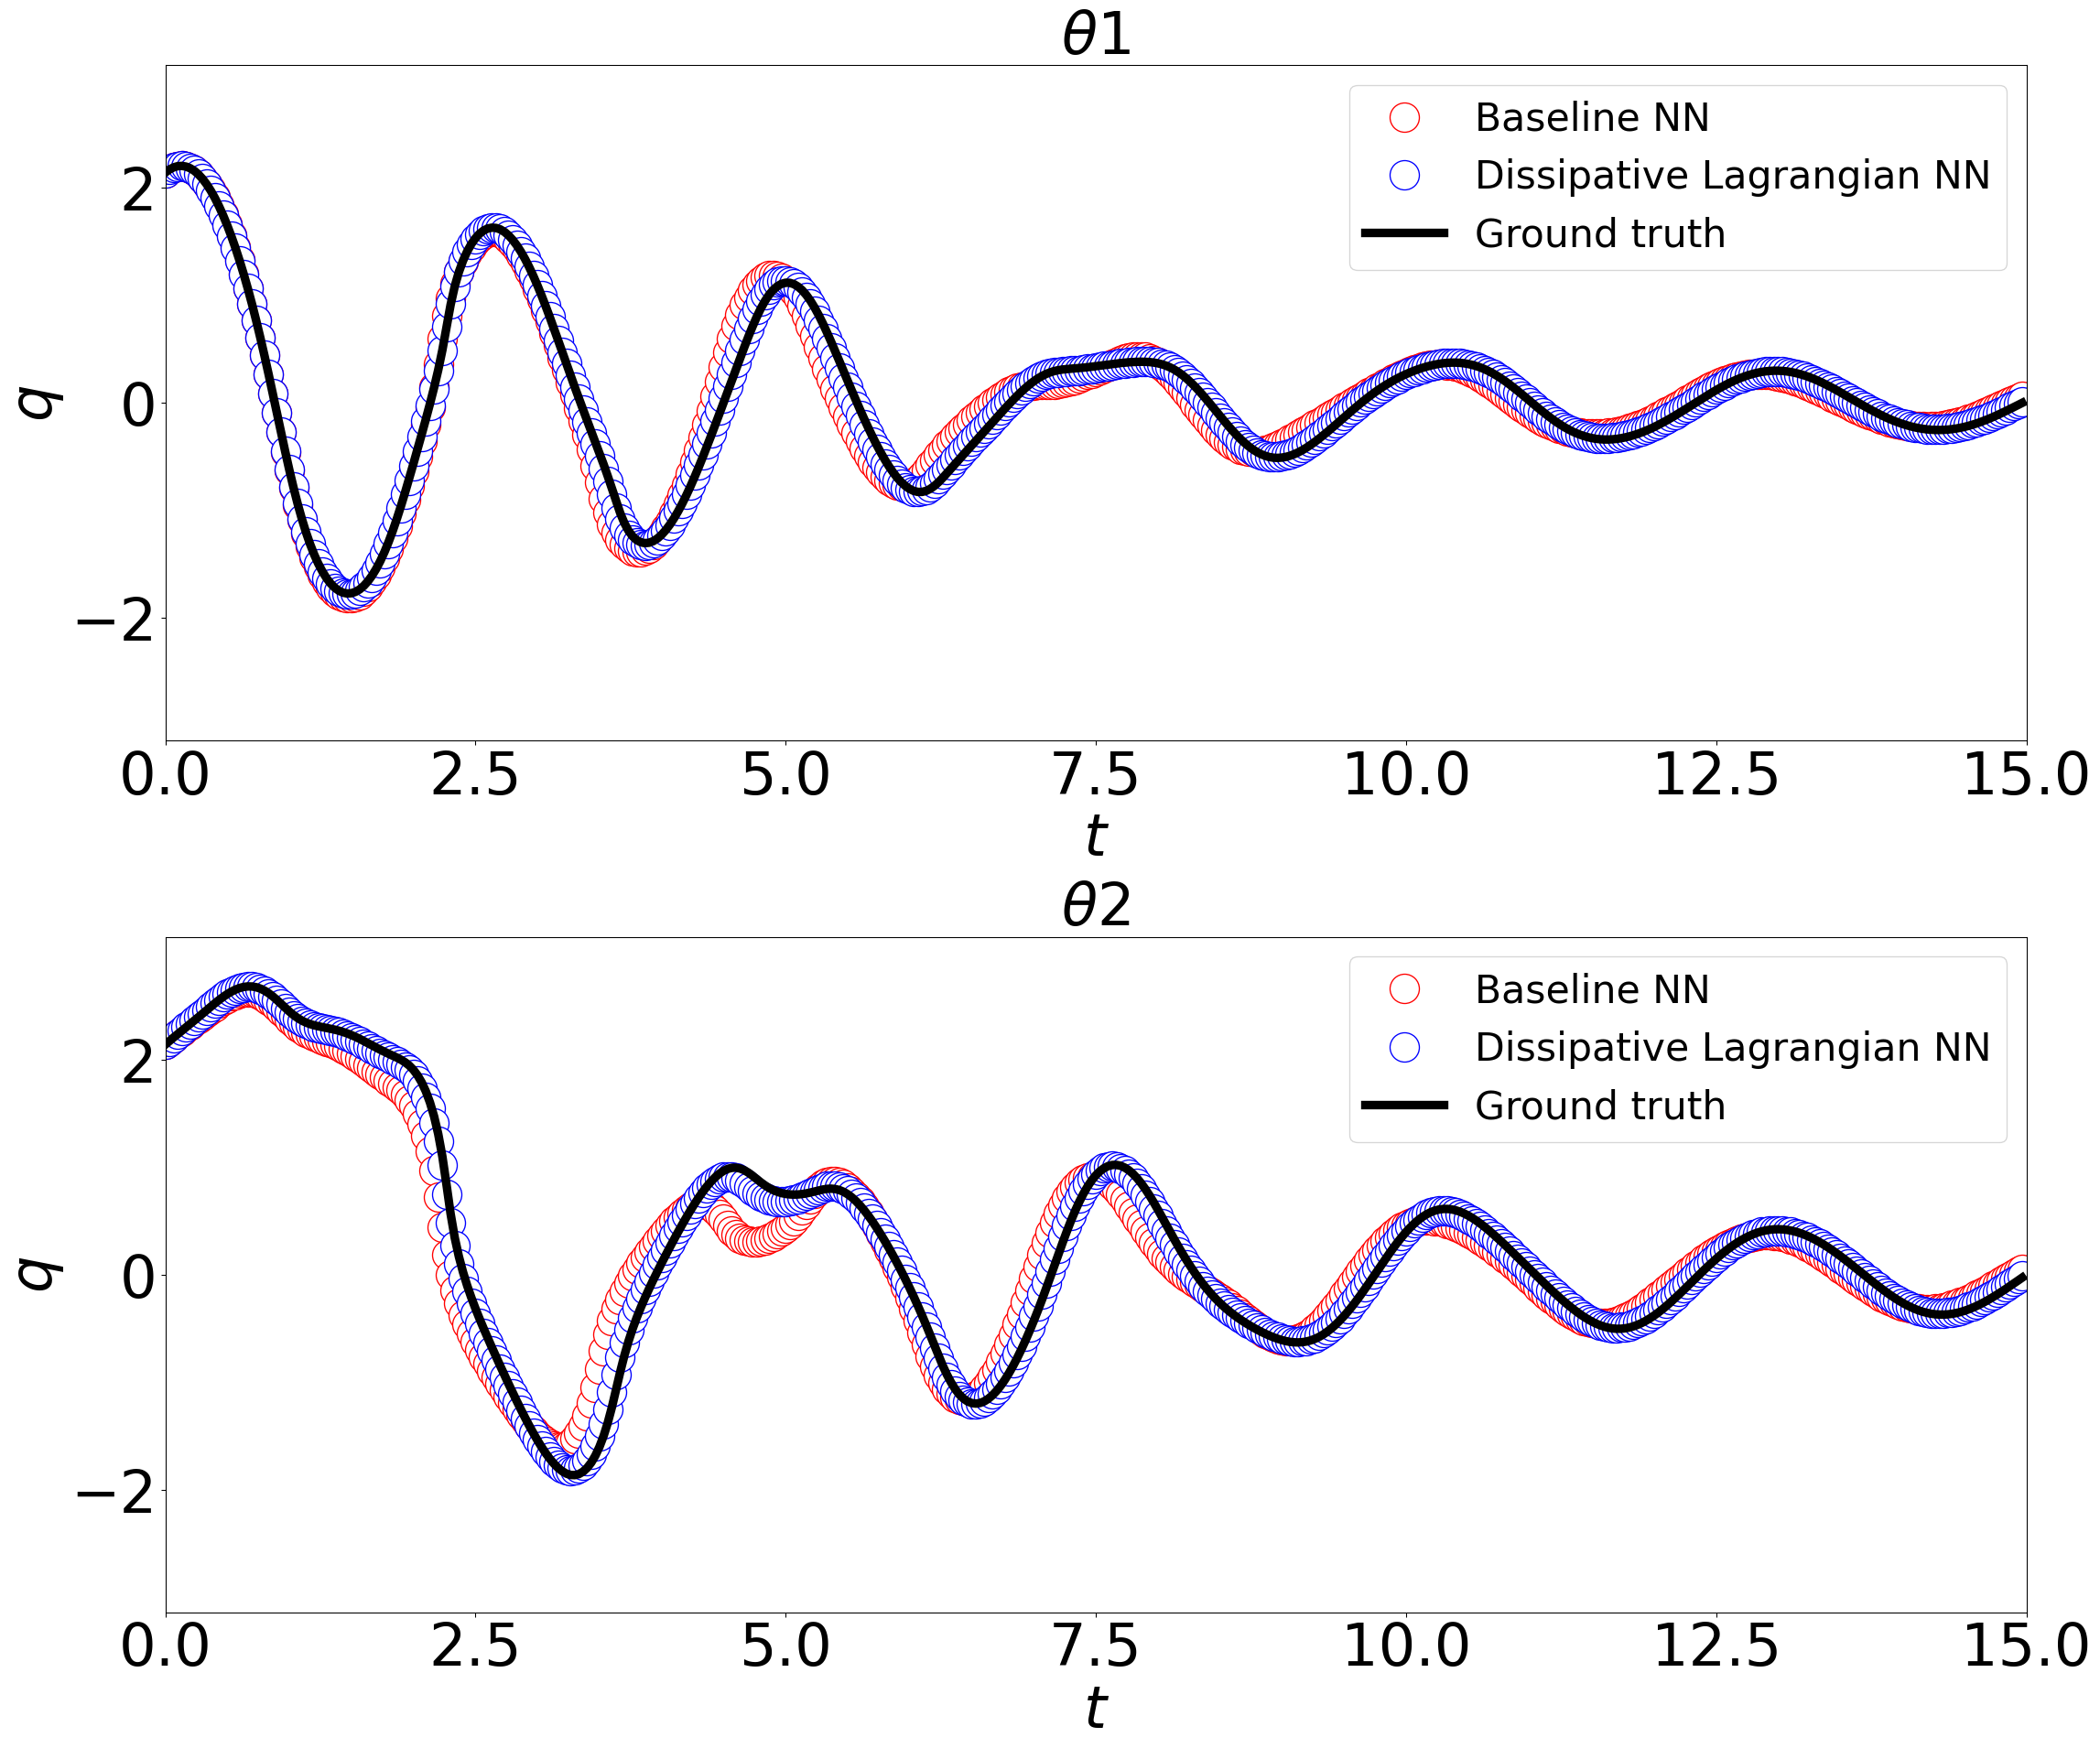

In [305]:
fig = plt.figure(figsize=[24,10*2], dpi=96)

plt.subplot(211)
plt.title(r'$\theta1$',fontsize = 48)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,15*30+1,5*30/2),np.arange(0,15+1,2.5))
plt.ylim(-np.pi,np.pi)
plt.xlim(0,15*30)
plt.plot(b1plot,'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dl1plot,'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(true_ivp['y'][0],'k',lw=7,label='Ground truth')
plt.legend(loc='upper right',  fontsize=32)

plt.subplot(212)
plt.title(r'$\theta2$',fontsize = 48)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,15*30+1,5*30/2),np.arange(0,15+1,2.5))
plt.ylim(-np.pi,np.pi)
plt.xlim(0,15*30)
plt.plot(b2plot,'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dl2plot,'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(true_ivp['y'][1],'k',lw=7,label='Ground truth')
plt.legend(loc='upper right',  fontsize=32)

plt.tight_layout()
plt.savefig('{}/dp_orbit.png'.format(EXPERIMENT_DIR))

plt.show()


In [306]:
BMSE = ((true_ivp['y'] - bc_ivp['y'])**2).mean()
DMSE = ((true_ivp['y'] - dlnn_ivp['y'])**2).mean()

In [307]:
print(BMSE)
print(DMSE)

9.456280579231695
9.377580099474594


In [308]:
from moviemaker import make_anim,save_anim

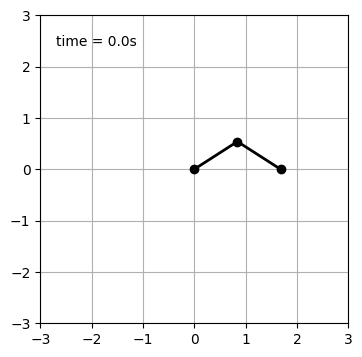

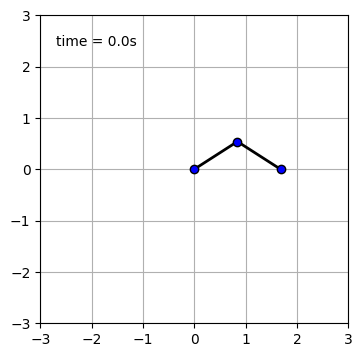

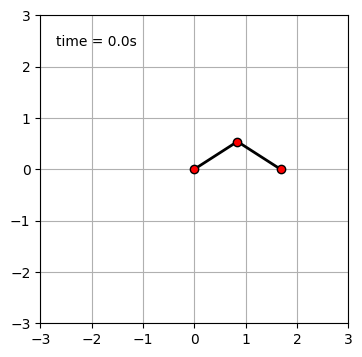

In [309]:
anim_actual = make_anim(true_ivp['y'].T,t_eval,len(t_eval),'k')
anim_dlnn = make_anim(dlnn_ivp['y'].T,t_eval,len(t_eval),'b')
anim_bc = make_anim(bc_ivp['y'].T,t_eval,len(t_eval),'r')

In [310]:
save_anim_format = "gif"

In [311]:
save_anim(anim_actual,'actual',EXPERIMENT_DIR,save_anim_format)
save_anim(anim_dlnn,'dlnn',EXPERIMENT_DIR,save_anim_format)
save_anim(anim_bc,'bc',EXPERIMENT_DIR,save_anim_format)

In [312]:
t_span = [0,8]
y0 = np.asarray([-2,1,-2,3])
t_eval = np.linspace(t_span[0], t_span[1], 8*30)
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}

In [313]:
true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)
dlnn_ivp = integrate_model(dlnn_model,t_span, y0,**kwargs)
bc_ivp = bc_integrate_model(bc_model, t_span, y0,**kwargs)

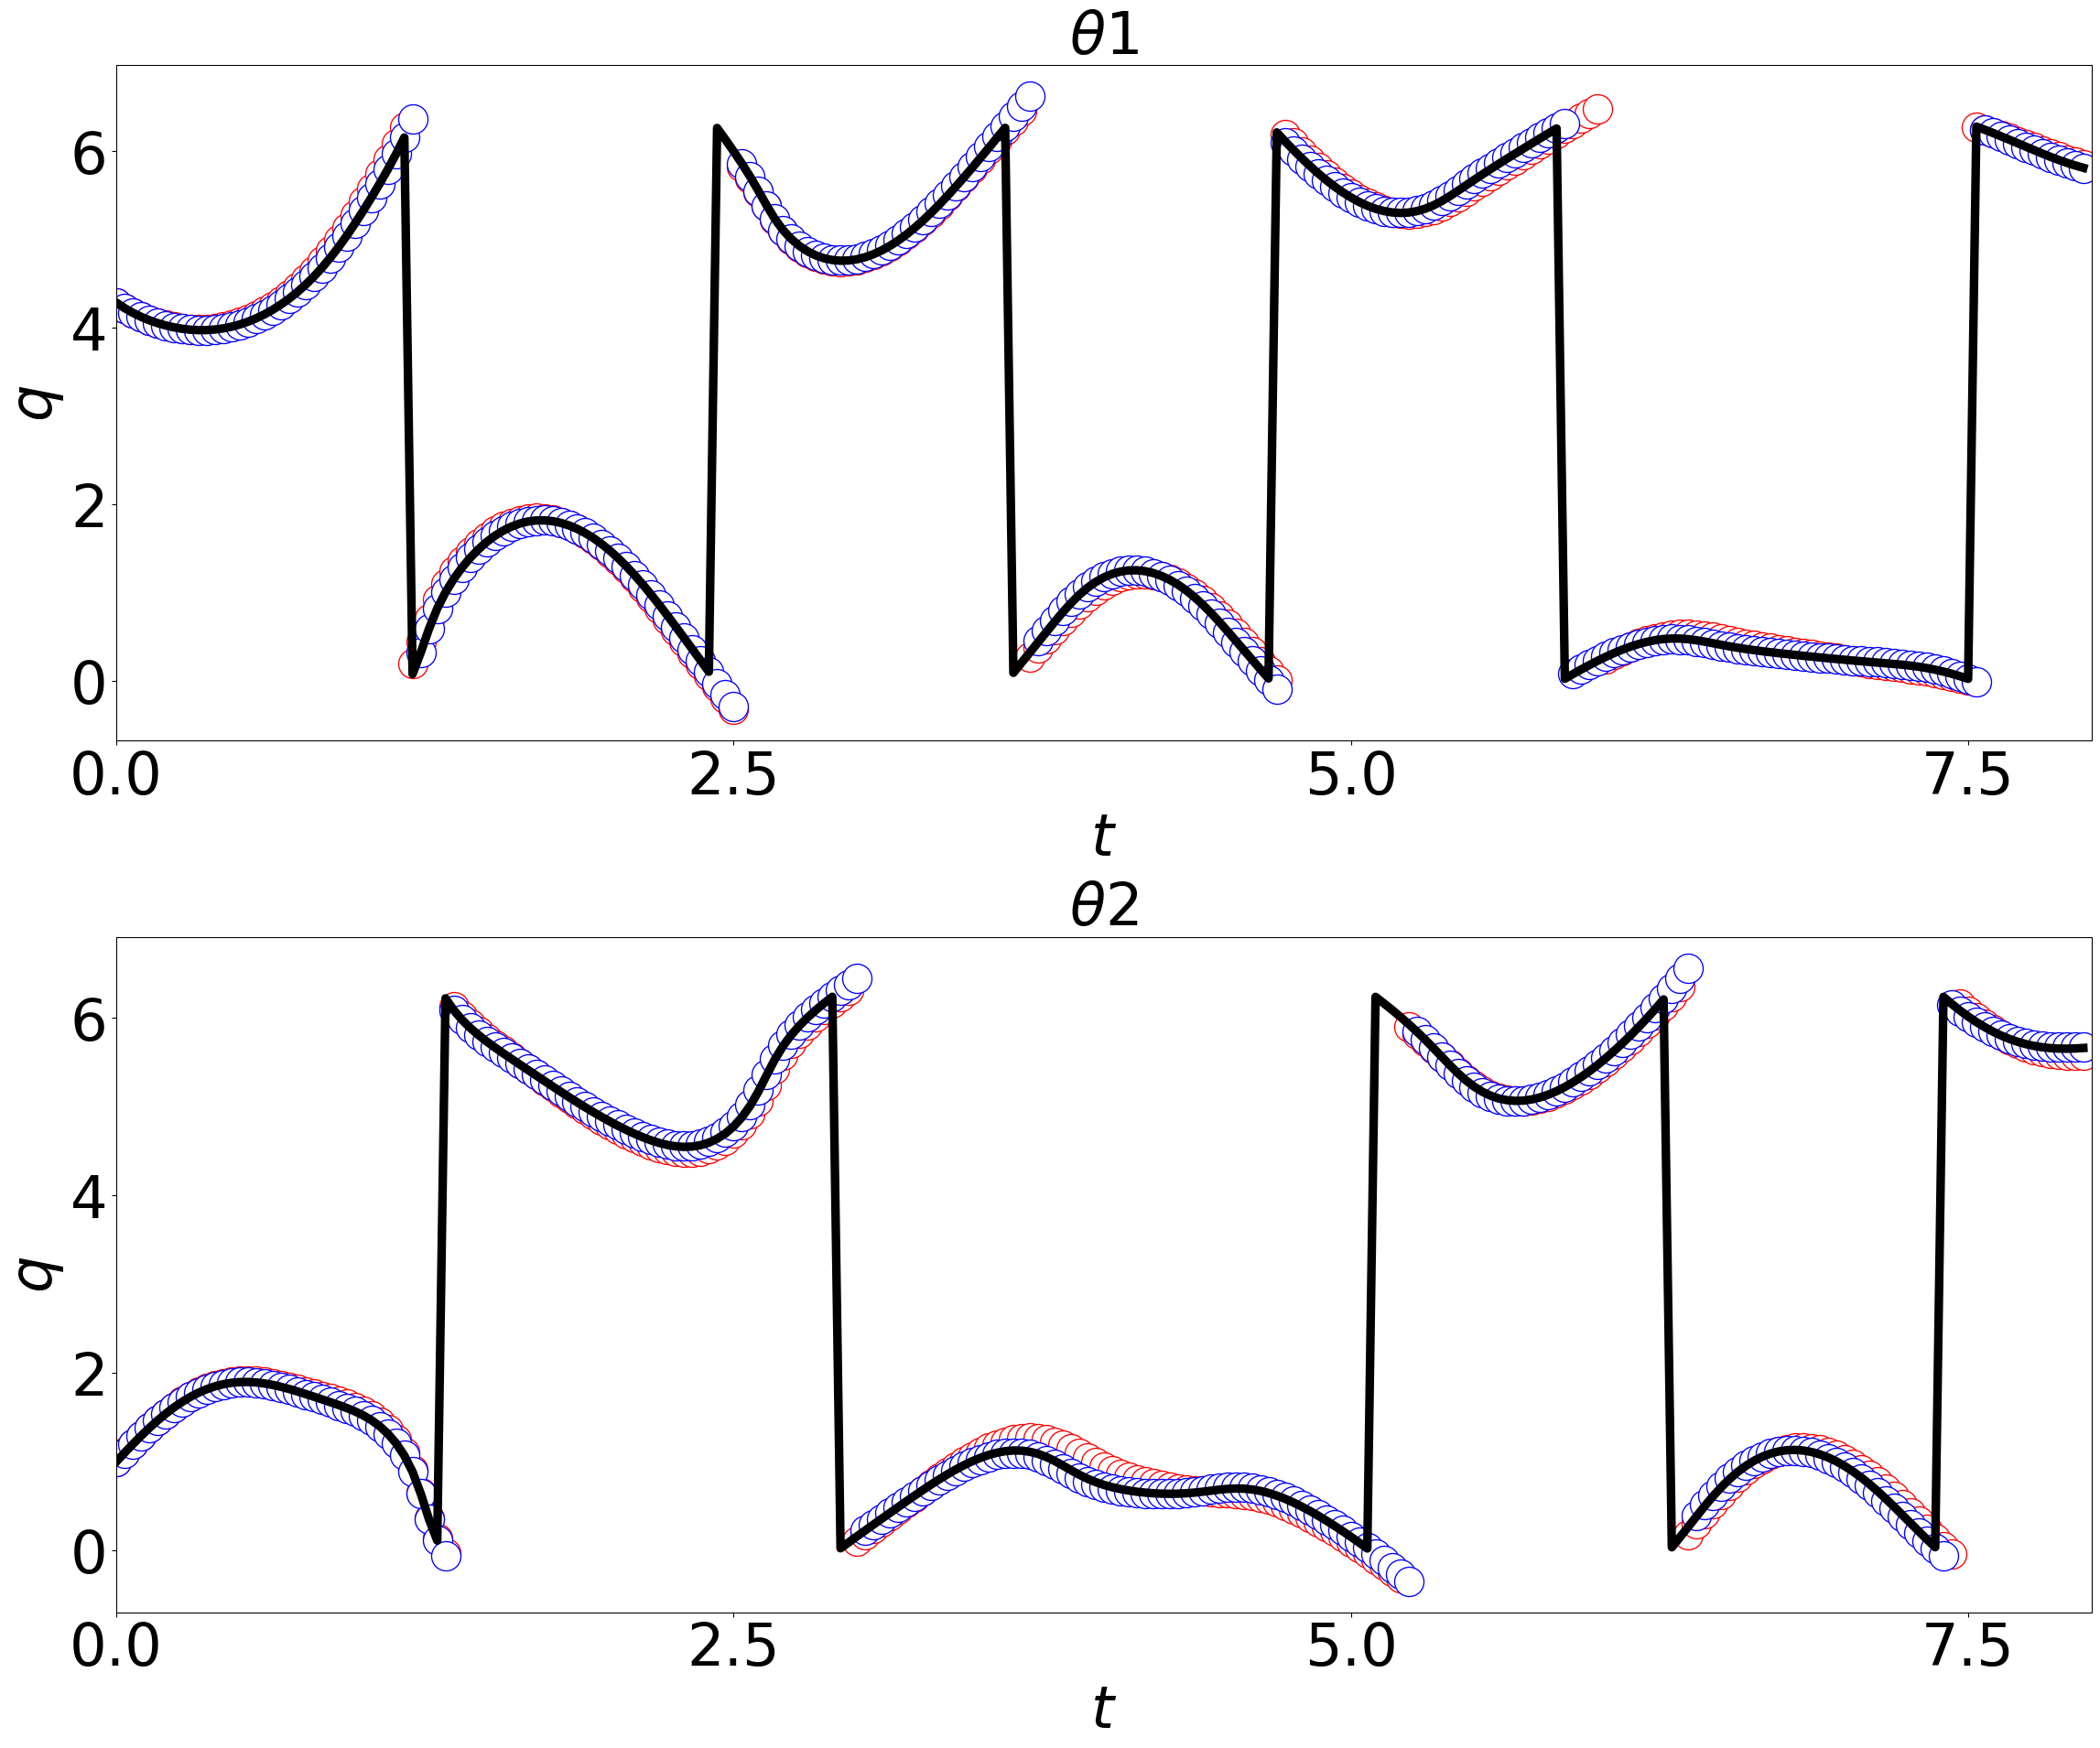

In [314]:
fig = plt.figure(figsize=[24,10*2], dpi=96)

plt.subplot(211)
plt.title(r'$\theta1$',fontsize = 48)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,8*30+1,5*30/2),np.arange(0,8+1,2.5))
# plt.ylim(-np.pi,np.pi)
plt.xlim(0,8*30)
plt.plot(bc_ivp['y'][0],'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dlnn_ivp['y'][0],'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k',lw=7,label='Ground truth')
# plt.legend(loc='upper right',  fontsize=32)

plt.subplot(212)
plt.title(r'$\theta2$',fontsize = 48)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,8*30+1,5*30/2),np.arange(0,8+1,2.5))
# plt.ylim(-np.pi,np.pi)
plt.xlim(0,8*30)
plt.plot(bc_ivp['y'][1],'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dlnn_ivp['y'][1],'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(np.mod(true_ivp['y'][1],2*np.pi),'k',lw=7,label='Ground truth')
# plt.legend(loc='upper right',  fontsize=32)

plt.tight_layout()
# plt.savefig('{}/dp_orbit.png'.format(EXPERIMENT_DIR))
plt.show()


In [315]:
t_span = [0,8]
y0 = np.asarray([np.pi,0,4,-2])
t_eval = np.linspace(t_span[0], t_span[1], 8*30)
kwargs = {'t_eval': t_eval, 'rtol': 1e-4}
true_ivp = solve_ivp(fun=lagrangian_dynamics_fn, t_span=t_span, y0=y0,**kwargs)
dlnn_ivp = integrate_model(dlnn_model,t_span, y0,**kwargs)
bc_ivp = bc_integrate_model(bc_model, t_span, y0,**kwargs)

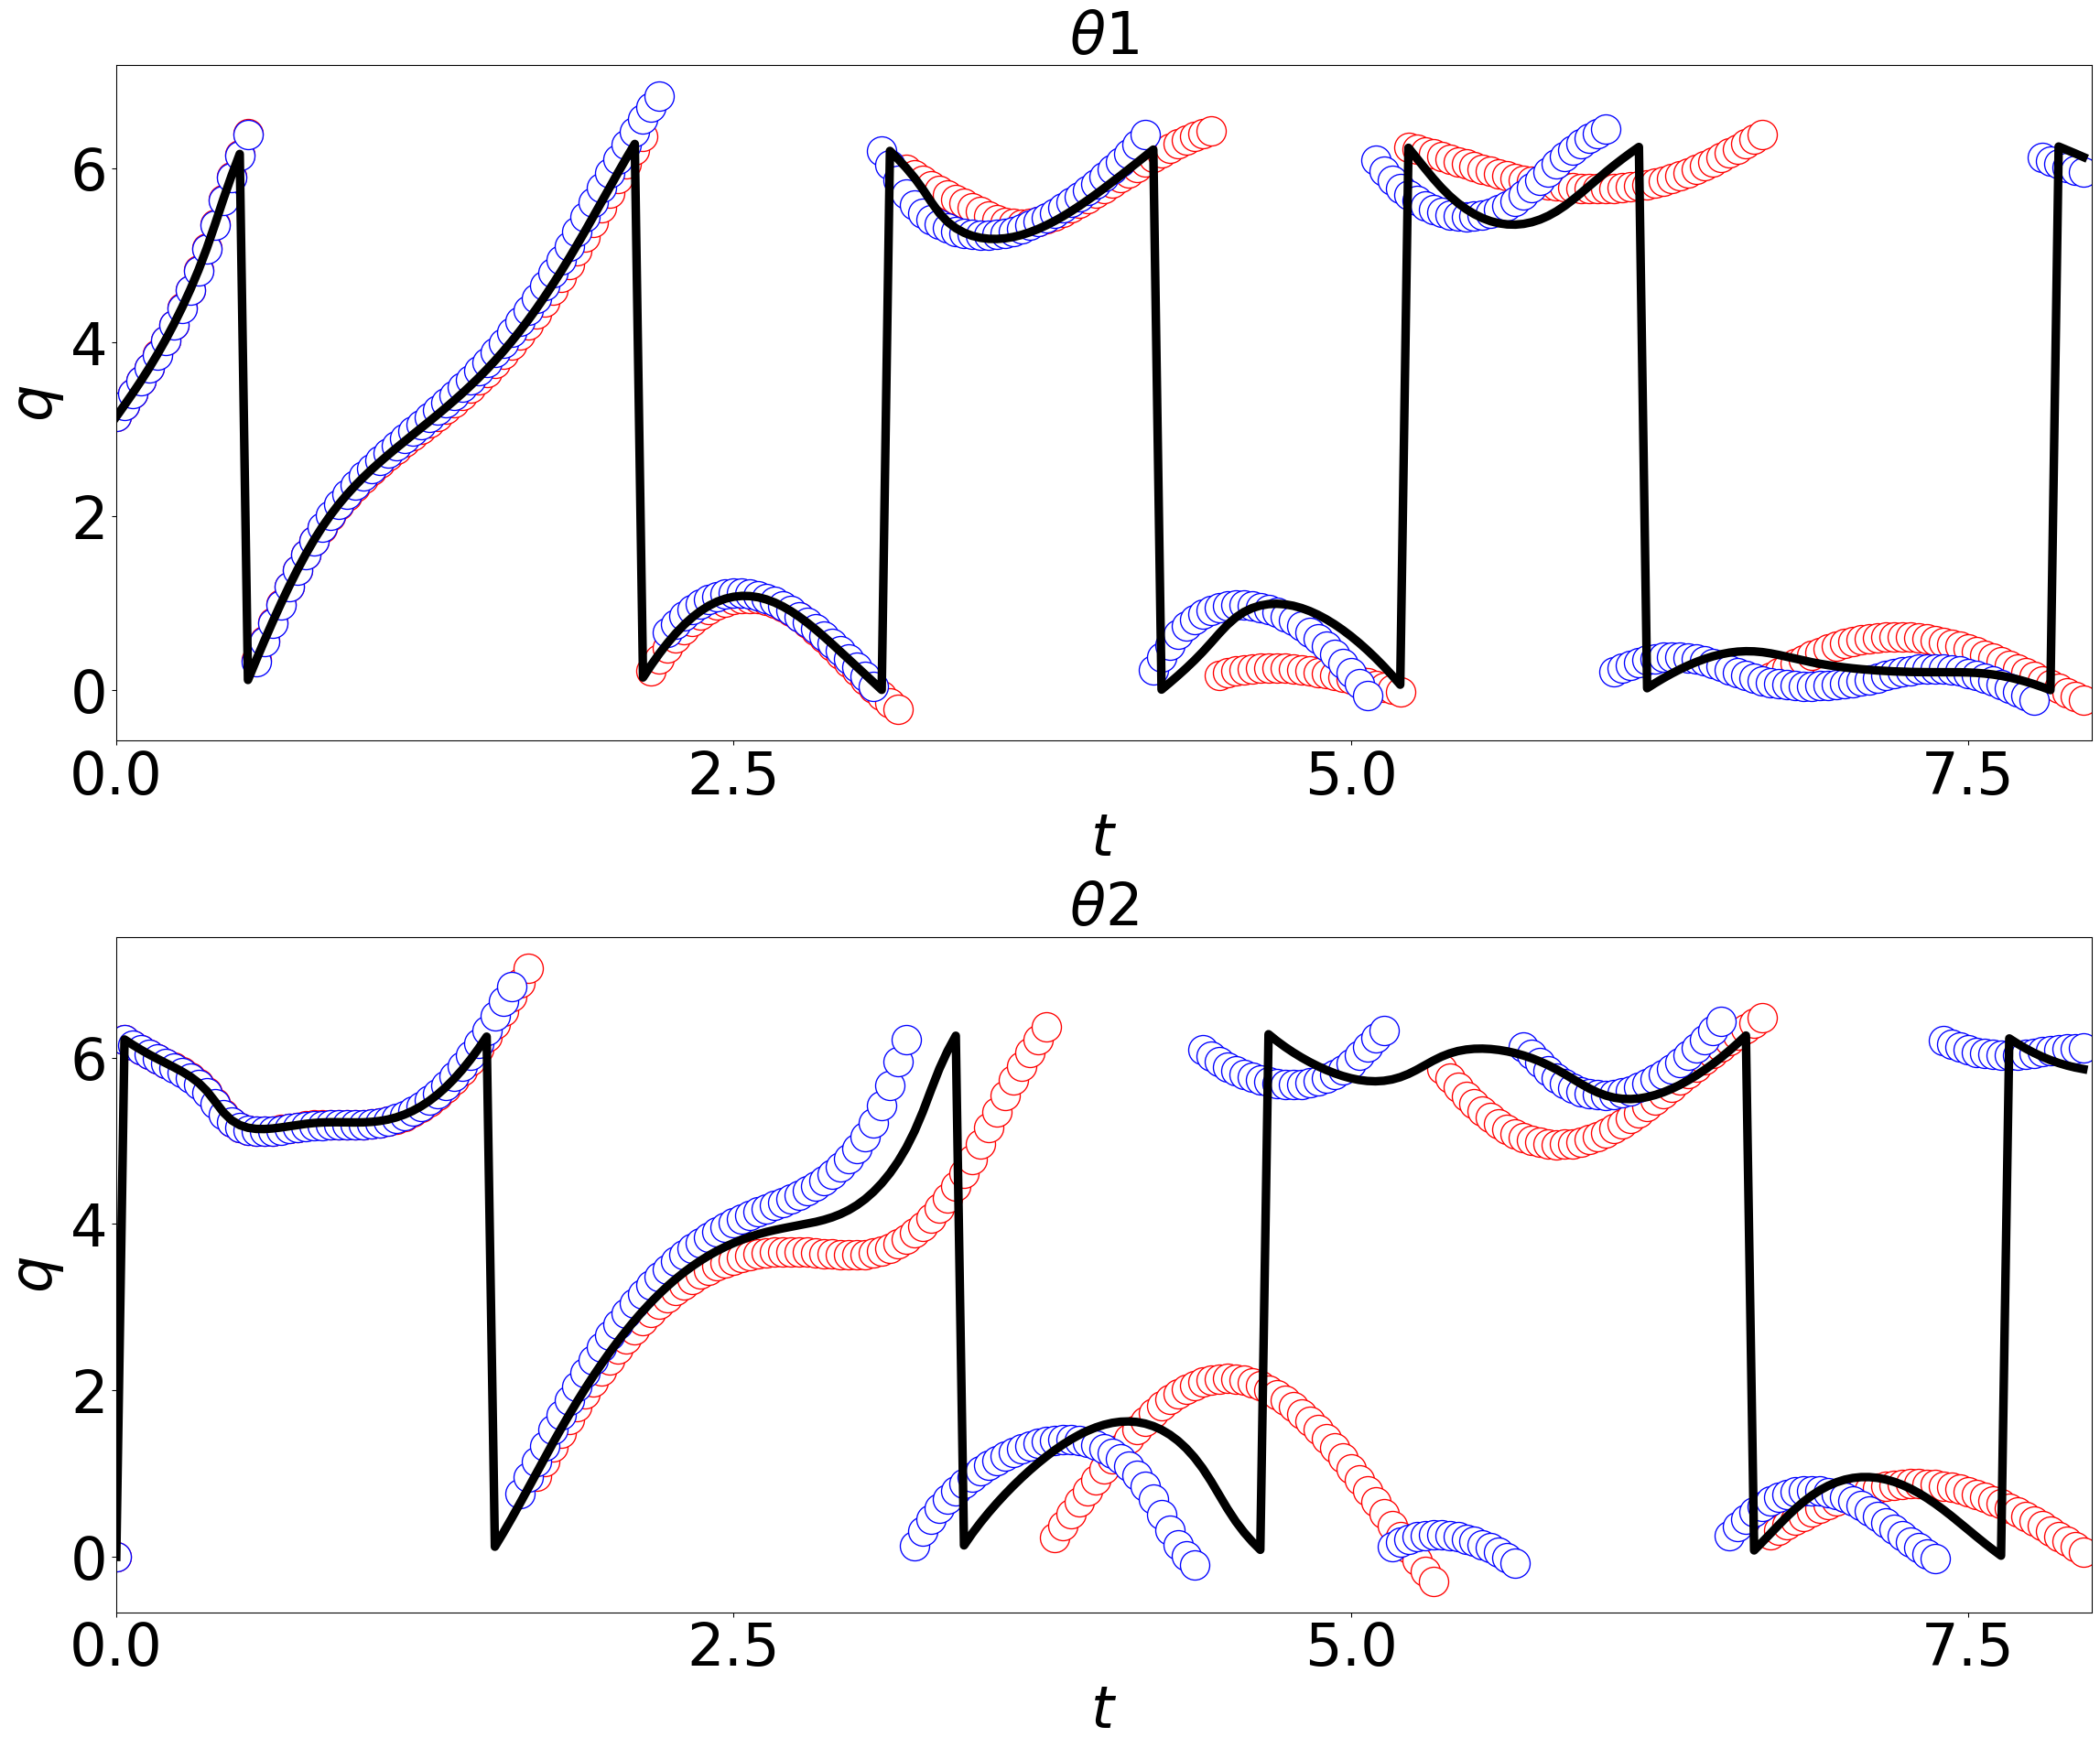

In [316]:
fig = plt.figure(figsize=[24,10*2], dpi=96)

plt.subplot(211)
plt.title(r'$\theta1$',fontsize = 48)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,8*30+1,5*30/2),np.arange(0,8+1,2.5))
# plt.ylim(-np.pi,np.pi)
plt.xlim(0,8*30)
plt.plot(bc_ivp['y'][0],'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dlnn_ivp['y'][0],'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(np.mod(true_ivp['y'][0],2*np.pi),'k',lw=7,label='Ground truth')
# plt.legend(loc='upper right',  fontsize=32)

plt.subplot(212)
plt.title(r'$\theta2$',fontsize = 48)
plt.xlabel(r'$t$',fontsize=48)
plt.ylabel(r'${q}$',fontsize=48)
plt.tick_params(labelsize=48)
plt.xticks(np.arange(0,8*30+1,5*30/2),np.arange(0,8+1,2.5))
# plt.ylim(-np.pi,np.pi)
plt.xlim(0,8*30)
plt.plot(bc_ivp['y'][1],'r.',markerfacecolor='white',markersize=48,label='Baseline NN')
plt.plot(dlnn_ivp['y'][1],'b.',markerfacecolor='white',markersize=48,label='Dissipative Lagrangian NN')
plt.plot(np.mod(true_ivp['y'][1],2*np.pi),'k',lw=7,label='Ground truth')
# plt.legend(loc='upper right',  fontsize=32)

plt.tight_layout()
# plt.savefig('{}/dp_orbit.png'.format(EXPERIMENT_DIR))
plt.show()


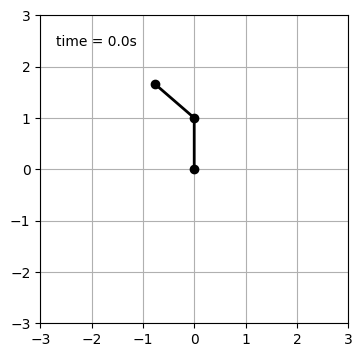

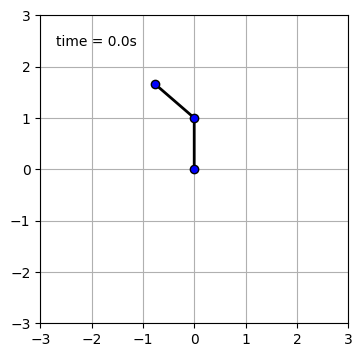

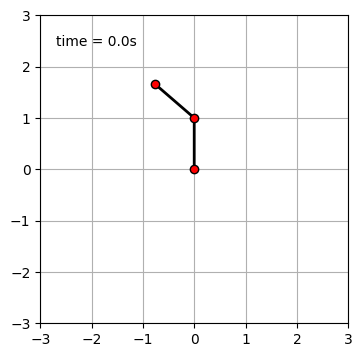

In [317]:
anim_actual = make_anim(true_ivp['y'].T,t_eval,len(t_eval),'k')
anim_dlnn = make_anim(dlnn_ivp['y'].T,t_eval,len(t_eval),'b')
anim_bc = make_anim(bc_ivp['y'].T,t_eval,len(t_eval),'r')

In [318]:
save_anim(anim_actual,'actual',EXPERIMENT_DIR,save_anim_format)
save_anim(anim_dlnn,'dlnn',EXPERIMENT_DIR,save_anim_format)
save_anim(anim_bc,'bc',EXPERIMENT_DIR,save_anim_format)